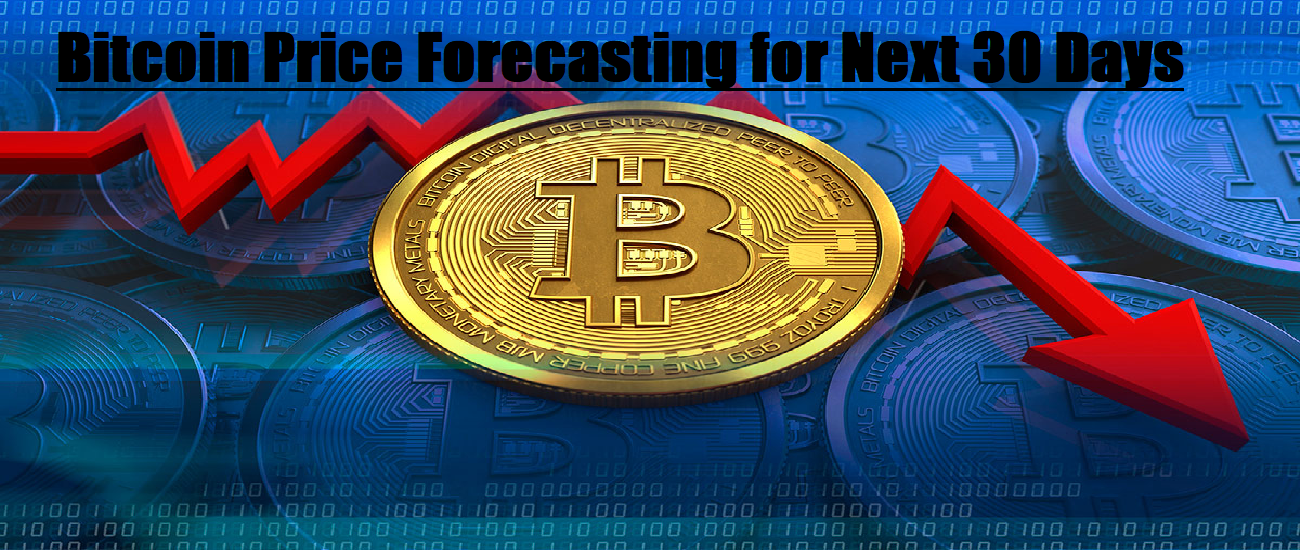

### Import required library

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
from datetime import date, timedelta
import yfinance as yf
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Setting Time interval for data

In [2]:
today=date.today()
d1=today.strftime("%Y-%m-%d")
end_date=d1
d2 = date.today() - timedelta(days=1826)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

### Fetching Bitcoin stock data from yfinance

In [3]:
data=yf.download('BTC-USD', 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
data.head()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2018-02-04  9175.700195  9334.870117  8031.220215  8277.009766  8277.009766   
2018-02-05  8270.540039  8364.839844  6756.680176  6955.270020  6955.270020   
2018-02-06  7051.750000  7850.700195  6048.259766  7754.000000  7754.000000   
2018-02-07  7755.490234  8509.110352  7236.790039  7621.299805  7621.299805   
2018-02-08  7637.859863  8558.769531  7637.859863  8265.589844  8265.589844   

                 Volume  
Date                     
2018-02-04   7073549824  
2018-02-05   9285289984  
2018-02-06  13999800320  
2018-02-07   9169280000  
2018-02-08   9346750464

In [4]:
data.reset_index(inplace=True)
data.head()

Date         Open         High          Low        Close    Adj Close  \
0 2018-02-04  9175.700195  9334.870117  8031.220215  8277.009766  8277.009766   
1 2018-02-05  8270.540039  8364.839844  6756.680176  6955.270020  6955.270020   
2 2018-02-06  7051.750000  7850.700195  6048.259766  7754.000000  7754.000000   
3 2018-02-07  7755.490234  8509.110352  7236.790039  7621.299805  7621.299805   
4 2018-02-08  7637.859863  8558.769531  7637.859863  8265.589844  8265.589844   

        Volume  
0   7073549824  
1   9285289984  
2  13999800320  
3   9169280000  
4   9346750464

In [5]:
data.shape

(1826, 7)

In [6]:
data.size

12782

In [7]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [8]:
data.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1826 non-null   datetime64[ns]
 1   Open       1826 non-null   float64       
 2   High       1826 non-null   float64       
 3   Low        1826 non-null   float64       
 4   Close      1826 non-null   float64       
 5   Adj Close  1826 non-null   float64       
 6   Volume     1826 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 100.0 KB


In [10]:
data.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

**No missing value.**

In [11]:
data.describe().round(2)

Open      High       Low     Close  Adj Close        Volume
count   1826.00   1826.00   1826.00   1826.00    1826.00  1.826000e+03
mean   20478.72  20977.45  19924.08  20484.12   20484.12  2.678185e+10
std    16961.13  17405.84  16442.03  16954.63   16954.63  1.976370e+10
min     3236.27   3275.38   3191.30   3236.76    3236.76  2.923670e+09
25%     7686.93   7908.67   7517.31   7682.07    7682.07  1.343613e+10
50%    11051.46  11390.96  10829.99  11075.43   11075.43  2.457629e+10
75%    33789.31  34790.41  32267.99  33740.26   33740.26  3.583049e+10
max    67549.73  68789.62  66382.06  67566.83   67566.83  3.509679e+11

**Maximum price of BitCoin is 67566.83, Minimum is 15787.28, average price is 37171.19 dollars**

### Bitcoin price

In [12]:
fig =px.line(data_frame=data,
                x=data["Date"],
                y=data["High"],
                title = "Bitcoin Price")
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

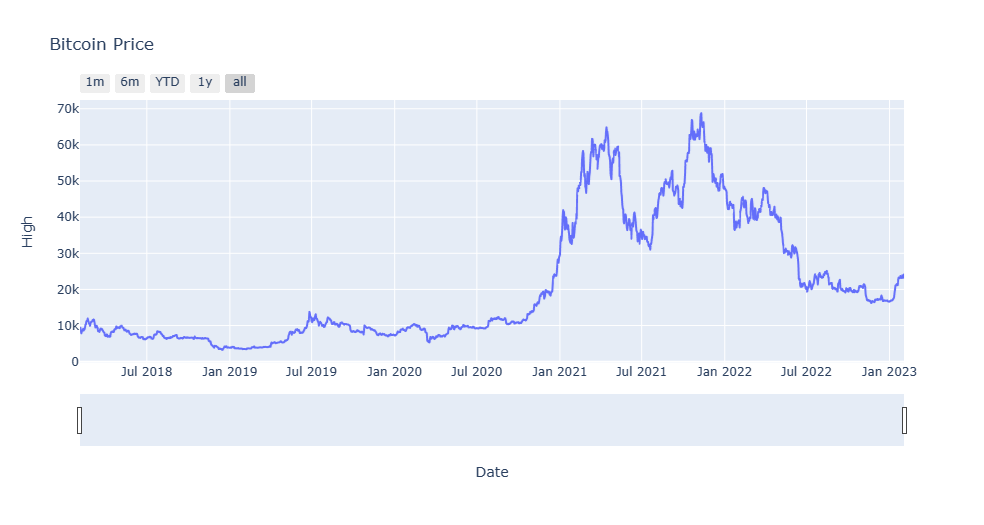

**BitCoin price was all time high in November 2021, and from then it is decresing..**

### Bitcoin Price forecasting

**Select 1 year data and then forecast then next 30 days Price.**

In [13]:
data=data[-365:]
data.head(),data.tail()

(           Date          Open          High           Low         Close  \
 1461 2022-02-04  37149.265625  41527.785156  37093.628906  41500.875000   
 1462 2022-02-05  41501.480469  41847.164062  41038.097656  41441.164062   
 1463 2022-02-06  41441.121094  42500.785156  41244.906250  42412.433594   
 1464 2022-02-07  42406.781250  44401.863281  41748.156250  43840.285156   
 1465 2022-02-08  43854.652344  45293.867188  42807.835938  44118.445312   
 
          Adj Close       Volume  
 1461  41500.875000  29412210792  
 1462  41441.164062  19652846215  
 1463  42412.433594  16142097334  
 1464  43840.285156  28641855926  
 1465  44118.445312  33079398868  ,
            Date          Open          High           Low         Close  \
 1821 2023-01-30  23774.648438  23789.347656  22657.582031  22840.138672   
 1822 2023-01-31  22840.796875  23225.021484  22765.568359  23139.283203   
 1823 2023-02-01  23137.835938  23764.539062  22877.750000  23723.769531   
 1824 2023-02-02  23720.824

In [14]:
data.set_index('Date', inplace=True)
data=data[['Close']]
data.head()

Close
Date                    
2022-02-04  41500.875000
2022-02-05  41441.164062
2022-02-06  42412.433594
2022-02-07  43840.285156
2022-02-08  44118.445312

In [15]:
train=data[:335]
test=data[335:]
train_len=len(train)
test_len=len(test)
test_len,train_len

(30, 335)

### 1. Naive method

In [16]:
naive=test.copy()
naive['forecast']=train['Close'][train_len-1]
naive

Close      forecast
Date                                  
2023-01-05  16836.736328  16863.238281
2023-01-06  16951.968750  16863.238281
2023-01-07  16955.078125  16863.238281
2023-01-08  17091.144531  16863.238281
2023-01-09  17196.554688  16863.238281
2023-01-10  17446.292969  16863.238281
2023-01-11  17934.896484  16863.238281
2023-01-12  18869.587891  16863.238281
2023-01-13  19909.574219  16863.238281
2023-01-14  20976.298828  16863.238281
2023-01-15  20880.798828  16863.238281
2023-01-16  21169.632812  16863.238281
2023-01-17  21161.519531  16863.238281
2023-01-18  20688.781250  16863.238281
2023-01-19  21086.792969  16863.238281
2023-01-20  22676.552734  16863.238281
2023-01-21  22777.625000  16863.238281
2023-01-22  22720.416016  16863.238281
2023-01-23  22934.431641  16863.238281
2023-01-24  22636.468750  16863.238281
2023-01-25  23117.859375  16863.238281
2023-01-26  23032.777344  16863.238281
2023-01-27  23078.728516  16863.238281
2023-01-28  23031.089844  16863.238281
2023-01-29  23774.566406  16863.238281
2023-01-30  22840.138672  16863.238281
2023-01-31  23139.283203  16863.238281
2023-02-01  23723.769531  16863.238281
2023-02-02  23471.871094  16863.238281
2023-02-03  23449.322266  16863.238281

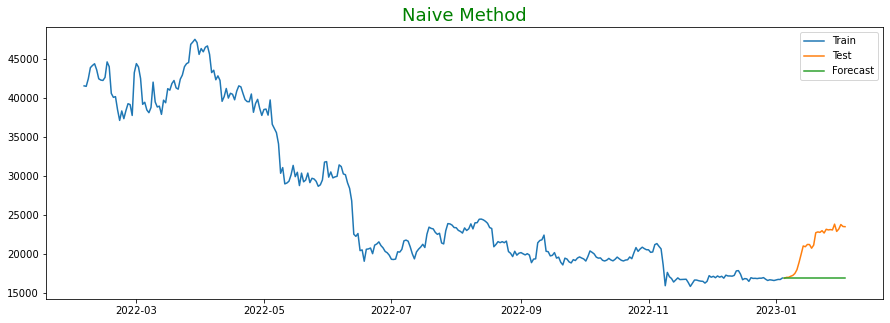

In [17]:
# plot the train, test & forecasted values
plt.figure(figsize=(15,5))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(naive['forecast'], label='Forecast')
plt.legend()
plt.title('Naive Method', fontsize=18, color='green');

In [18]:
#evaluate the model
rmse=np.sqrt(mean_squared_error(test['Close'],naive['forecast'])).round(2)
mape=mean_absolute_percentage_error(test['Close'],naive['forecast']).round(4)*100

results=pd.DataFrame({'Method':['Naive Method'], 'RMSE':[rmse],'MAPE':[mape]})
results

Method     RMSE   MAPE
0  Naive Method  4836.15  18.74

**RMSE is very high.**

### 2. Simple Moving average

In [19]:
avg=test.copy()
avg['forecast']=train['Close'].mean()
avg

Close     forecast
Date                                 
2023-01-05  16836.736328  26781.01176
2023-01-06  16951.968750  26781.01176
2023-01-07  16955.078125  26781.01176
2023-01-08  17091.144531  26781.01176
2023-01-09  17196.554688  26781.01176
2023-01-10  17446.292969  26781.01176
2023-01-11  17934.896484  26781.01176
2023-01-12  18869.587891  26781.01176
2023-01-13  19909.574219  26781.01176
2023-01-14  20976.298828  26781.01176
2023-01-15  20880.798828  26781.01176
2023-01-16  21169.632812  26781.01176
2023-01-17  21161.519531  26781.01176
2023-01-18  20688.781250  26781.01176
2023-01-19  21086.792969  26781.01176
2023-01-20  22676.552734  26781.01176
2023-01-21  22777.625000  26781.01176
2023-01-22  22720.416016  26781.01176
2023-01-23  22934.431641  26781.01176
2023-01-24  22636.468750  26781.01176
2023-01-25  23117.859375  26781.01176
2023-01-26  23032.777344  26781.01176
2023-01-27  23078.728516  26781.01176
2023-01-28  23031.089844  26781.01176
2023-01-29  23774.566406  26781.01176
2023-01-30  22840.138672  26781.01176
2023-01-31  23139.283203  26781.01176
2023-02-01  23723.769531  26781.01176
2023-02-02  23471.871094  26781.01176
2023-02-03  23449.322266  26781.01176

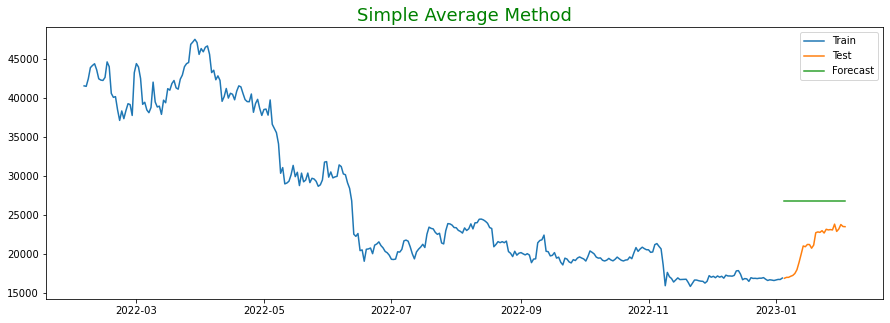

In [20]:
# plot the train, test & forecasted values
plt.figure(figsize=(15,5))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(avg['forecast'], label='Forecast')
plt.legend()
plt.title('Simple Average Method', fontsize=18, color='green');

In [21]:
#evaluate the model
rmse=np.sqrt(mean_squared_error(test['Close'],avg['forecast'])).round(2)
mape=mean_absolute_percentage_error(test['Close'],avg['forecast']).round(4)*100

result=pd.DataFrame({'Method':['Simple Average Method'], 'RMSE':[rmse],'MAPE':[mape]})
results=pd.concat([results,result])
results

Method     RMSE   MAPE
0           Naive Method  4836.15  18.74
0  Simple Average Method  6218.02  29.07

### 3. Simple Moving Average

In [22]:
sma=data.copy()
sma['forecast']=data['Close'].rolling(window=30).mean()
#sma['forecast'][train_len:]=sma['forecast'][train_len-1]
sma

Close      forecast
Date                                  
2022-02-04  41500.875000           NaN
2022-02-05  41441.164062           NaN
2022-02-06  42412.433594           NaN
2022-02-07  43840.285156           NaN
2022-02-08  44118.445312           NaN
...                  ...           ...
2023-01-30  22840.138672  20154.431966
2023-01-31  23139.283203  20371.572070
2023-02-01  23723.769531  20606.082031
2023-02-02  23471.871094  20832.482487
2023-02-03  23449.322266  21052.018620

[365 rows x 2 columns]

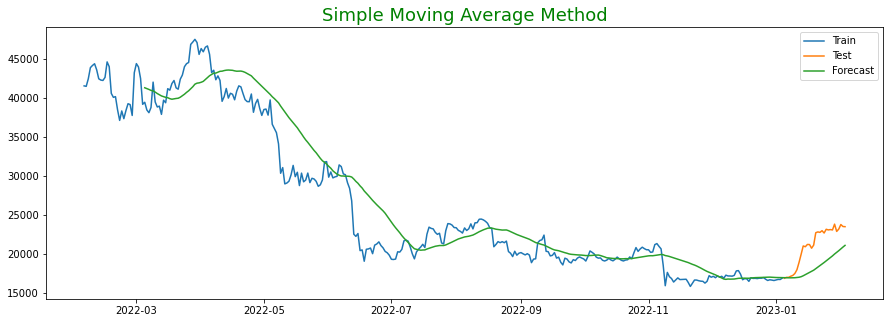

In [23]:
# plot the train, test & forecasted values
plt.figure(figsize=(15,5))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(sma['forecast'], label='Forecast')
plt.legend()
plt.title('Simple Moving Average Method', fontsize=18, color='green');

In [24]:
#evaluate the model
rmse=np.sqrt(mean_squared_error(test['Close'],sma['forecast'][train_len:])).round(2)
mape=mean_absolute_percentage_error(test['Close'],sma['forecast'][train_len:]).round(4)*100

result=pd.DataFrame({'Method':['Simple Moving Average'], 'RMSE':[rmse],'MAPE':[mape]})
results=pd.concat([results,result])
results

Method     RMSE   MAPE
0           Naive Method  4836.15  18.74
0  Simple Average Method  6218.02  29.07
0  Simple Moving Average  3083.26  12.30

**RMSE is less than that of Naive Method.**

### 4. Simple Exponential Smoothing

In [25]:
warnings.filterwarnings('ignore')

In [26]:
model=SimpleExpSmoothing(train)
model=model.fit(optimized=True)
ses=test.copy()
ses['forecast']=model.forecast(len(test))
ses

Close      forecast
Date                                  
2023-01-05  16836.736328  16858.104675
2023-01-06  16951.968750  16858.104675
2023-01-07  16955.078125  16858.104675
2023-01-08  17091.144531  16858.104675
2023-01-09  17196.554688  16858.104675
2023-01-10  17446.292969  16858.104675
2023-01-11  17934.896484  16858.104675
2023-01-12  18869.587891  16858.104675
2023-01-13  19909.574219  16858.104675
2023-01-14  20976.298828  16858.104675
2023-01-15  20880.798828  16858.104675
2023-01-16  21169.632812  16858.104675
2023-01-17  21161.519531  16858.104675
2023-01-18  20688.781250  16858.104675
2023-01-19  21086.792969  16858.104675
2023-01-20  22676.552734  16858.104675
2023-01-21  22777.625000  16858.104675
2023-01-22  22720.416016  16858.104675
2023-01-23  22934.431641  16858.104675
2023-01-24  22636.468750  16858.104675
2023-01-25  23117.859375  16858.104675
2023-01-26  23032.777344  16858.104675
2023-01-27  23078.728516  16858.104675
2023-01-28  23031.089844  16858.104675
2023-01-29  23774.566406  16858.104675
2023-01-30  22840.138672  16858.104675
2023-01-31  23139.283203  16858.104675
2023-02-01  23723.769531  16858.104675
2023-02-02  23471.871094  16858.104675
2023-02-03  23449.322266  16858.104675

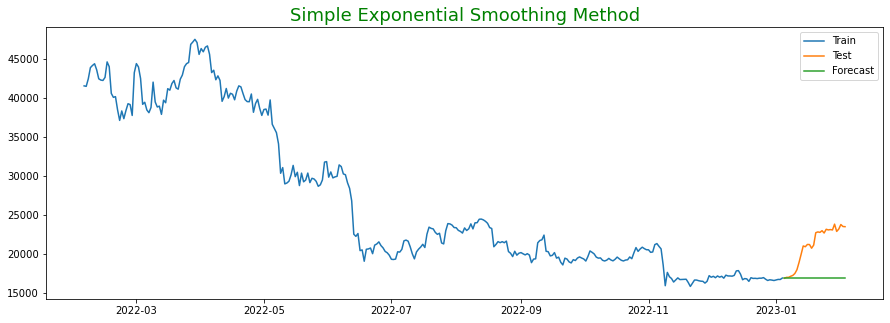

In [27]:
# plot the train, test & forecasted values
plt.figure(figsize=(15,5))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(ses['forecast'], label='Forecast')
plt.legend()
plt.title('Simple Exponential Smoothing Method', fontsize=18, color='green');

In [28]:
#evaluate the model
rmse=np.sqrt(mean_squared_error(test['Close'],ses['forecast'])).round(2)
mape=mean_absolute_percentage_error(test['Close'],ses['forecast']).round(4)*100

result=pd.DataFrame({'Method':['Simple Explonential Smoothing'], 'RMSE':[rmse],'MAPE':[mape]})
results=pd.concat([results,result])
results

Method     RMSE   MAPE
0                   Naive Method  4836.15  18.74
0          Simple Average Method  6218.02  29.07
0          Simple Moving Average  3083.26  12.30
0  Simple Explonential Smoothing  4840.60  18.76

### 5. Holt's method with trend

In [29]:
model = ExponentialSmoothing(np.asarray(train['Close']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model = model.fit(optimized=True)
holt_trend = test.copy()
holt_trend['forecast'] = model.forecast(test_len)
holt_trend

Close      forecast
Date                                  
2023-01-05  16836.736328  16834.428226
2023-01-06  16951.968750  16811.661979
2023-01-07  16955.078125  16788.895731
2023-01-08  17091.144531  16766.129483
2023-01-09  17196.554688  16743.363236
2023-01-10  17446.292969  16720.596988
2023-01-11  17934.896484  16697.830741
2023-01-12  18869.587891  16675.064493
2023-01-13  19909.574219  16652.298246
2023-01-14  20976.298828  16629.531998
2023-01-15  20880.798828  16606.765751
2023-01-16  21169.632812  16583.999503
2023-01-17  21161.519531  16561.233256
2023-01-18  20688.781250  16538.467008
2023-01-19  21086.792969  16515.700761
2023-01-20  22676.552734  16492.934513
2023-01-21  22777.625000  16470.168265
2023-01-22  22720.416016  16447.402018
2023-01-23  22934.431641  16424.635770
2023-01-24  22636.468750  16401.869523
2023-01-25  23117.859375  16379.103275
2023-01-26  23032.777344  16356.337028
2023-01-27  23078.728516  16333.570780
2023-01-28  23031.089844  16310.804533
2023-01-29  23774.566406  16288.038285
2023-01-30  22840.138672  16265.272038
2023-01-31  23139.283203  16242.505790
2023-02-01  23723.769531  16219.739543
2023-02-02  23471.871094  16196.973295
2023-02-03  23449.322266  16174.207048

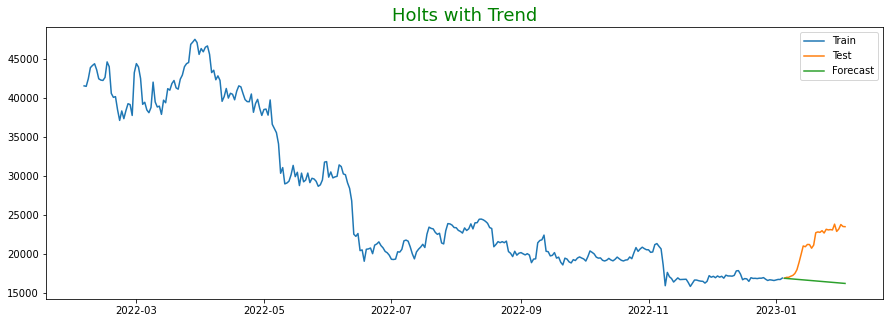

In [30]:
# plot the train, test & forecasted values
plt.figure(figsize=(15,5))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(holt_trend['forecast'], label='Forecast')
plt.legend()
plt.title('Holts with Trend', fontsize=18, color='green');

In [31]:
#evaluate the model
rmse=np.sqrt(mean_squared_error(test['Close'],holt_trend['forecast'])).round(2)
mape=mean_absolute_percentage_error(test['Close'],holt_trend['forecast']).round(4)*100

result=pd.DataFrame({'Method':["Holt's With Trend"], 'RMSE':[rmse],'MAPE':[mape]})
results=pd.concat([results,result])
results

Method     RMSE   MAPE
0                   Naive Method  4836.15  18.74
0          Simple Average Method  6218.02  29.07
0          Simple Moving Average  3083.26  12.30
0  Simple Explonential Smoothing  4840.60  18.76
0              Holt's With Trend  5239.54  20.35

### 6. Holt winters additive method with trend & seasonality

In [32]:
hwa=test.copy()
model = ExponentialSmoothing(np.asarray(train['Close']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model=model.fit(optimized=True)
hwa['forecast']=model.forecast(test_len)
hwa

Close      forecast
Date                                  
2023-01-05  16836.736328  17085.592887
2023-01-06  16951.968750  17286.751937
2023-01-07  16955.078125  17487.668060
2023-01-08  17091.144531  17785.159170
2023-01-09  17196.554688  18221.363629
2023-01-10  17446.292969  18079.407780
2023-01-11  17934.896484  17762.953182
2023-01-12  18869.587891  17408.973687
2023-01-13  19909.574219  17162.367032
2023-01-14  20976.298828  16976.767666
2023-01-15  20880.798828  16911.733723
2023-01-16  21169.632812  16890.753841
2023-01-17  21161.519531  17129.149078
2023-01-18  20688.781250  17330.308129
2023-01-19  21086.792969  17531.224252
2023-01-20  22676.552734  17828.715361
2023-01-21  22777.625000  18264.919821
2023-01-22  22720.416016  18122.963972
2023-01-23  22934.431641  17806.509374
2023-01-24  22636.468750  17452.529878
2023-01-25  23117.859375  17205.923224
2023-01-26  23032.777344  17020.323858
2023-01-27  23078.728516  16955.289915
2023-01-28  23031.089844  16934.310033
2023-01-29  23774.566406  17172.705270
2023-01-30  22840.138672  17373.864320
2023-01-31  23139.283203  17574.780444
2023-02-01  23723.769531  17872.271553
2023-02-02  23471.871094  18308.476012
2023-02-03  23449.322266  18166.520164

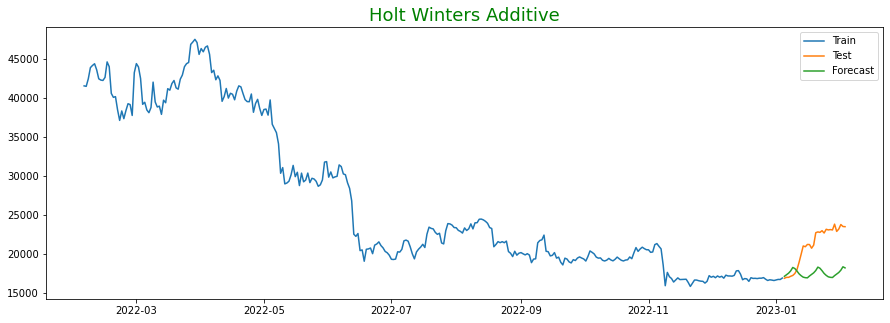

In [33]:
# plot the train, test & forecasted values
plt.figure(figsize=(15,5))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(hwa['forecast'], label='Forecast')
plt.legend()
plt.title('Holt Winters Additive', fontsize=18, color='green');

In [34]:
#evaluate the model
rmse=np.sqrt(mean_squared_error(test['Close'],hwa['forecast'])).round(2)
mape=mean_absolute_percentage_error(test['Close'],hwa['forecast']).round(4)*100

result=pd.DataFrame({'Method':["Holt Winters Additive"], 'RMSE':[rmse],'MAPE':[mape]})
results=pd.concat([results,result])
results

Method     RMSE   MAPE
0                   Naive Method  4836.15  18.74
0          Simple Average Method  6218.02  29.07
0          Simple Moving Average  3083.26  12.30
0  Simple Explonential Smoothing  4840.60  18.76
0              Holt's With Trend  5239.54  20.35
0          Holt Winters Additive  4318.63  16.98

### 7. Holt winters multiplicative method with trend & seasonality

In [35]:
hwm=test.copy()
model = ExponentialSmoothing(np.asarray(train['Close']) ,seasonal_periods=12 ,trend='mul', seasonal='add')
model=model.fit(optimized=True)
hwm['forecast']=model.forecast(test_len)
hwm

Close      forecast
Date                                  
2023-01-05  16836.736328  16925.093093
2023-01-06  16951.968750  16972.938749
2023-01-07  16955.078125  17010.425711
2023-01-08  17091.144531  17138.910649
2023-01-09  17196.554688  17410.643206
2023-01-10  17446.292969  17123.324361
2023-01-11  17934.896484  16684.339201
2023-01-12  18869.587891  16219.843942
2023-01-13  19909.574219  15866.314579
2023-01-14  20976.298828  15577.459867
2023-01-15  20880.798828  15402.032516
2023-01-16  21169.632812  15250.250772
2023-01-17  21161.519531  15351.275046
2023-01-18  20688.781250  15411.867088
2023-01-19  21086.792969  15461.997202
2023-01-20  22676.552734  15603.022896
2023-01-21  22777.625000  15887.194640
2023-01-22  22720.416016  15612.214237
2023-01-23  22934.431641  15185.467591
2023-01-24  22636.468750  14733.111725
2023-01-25  23117.859375  14391.623438
2023-01-26  23032.777344  14114.712281
2023-01-27  23078.728516  13951.131753
2023-01-28  23031.089844  13811.100886
2023-01-29  23774.566406  13923.780866
2023-01-30  22840.138672  13995.934213
2023-01-31  23139.283203  14057.531998
2023-02-01  23723.769531  14209.932486
2023-02-02  23471.871094  14505.386899
2023-02-03  23449.322266  14241.597786

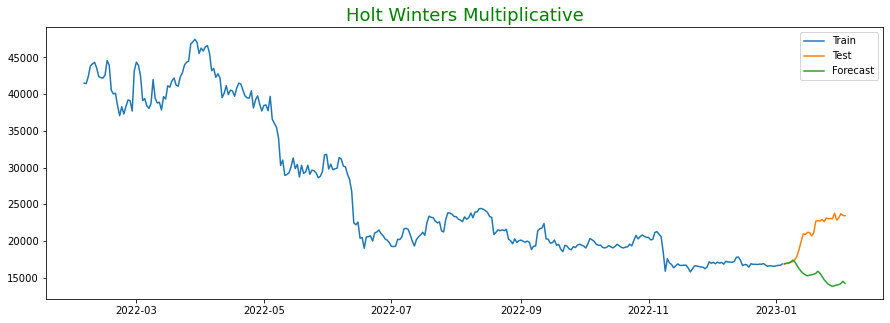

In [36]:
# plot the train, test & forecasted values
plt.figure(figsize=(15,5))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(hwm['forecast'], label='Forecast')
plt.legend()
plt.title('Holt Winters Multiplicative', fontsize=18, color='green');

In [37]:
#evaluate the model
rmse=np.sqrt(mean_squared_error(test['Close'],hwm['forecast'])).round(2)
mape=mean_absolute_percentage_error(test['Close'],hwm['forecast']).round(4)*100

result=pd.DataFrame({'Method':["Holt Winters Multiplicative"], 'RMSE':[rmse],'MAPE':[mape]})
results=pd.concat([results,result])
results

Method     RMSE   MAPE
0                   Naive Method  4836.15  18.74
0          Simple Average Method  6218.02  29.07
0          Simple Moving Average  3083.26  12.30
0  Simple Explonential Smoothing  4840.60  18.76
0              Holt's With Trend  5239.54  20.35
0          Holt Winters Additive  4318.63  16.98
0    Holt Winters Multiplicative  6634.56  25.32

### 8. Auto Regression(AR)

In [38]:
model=sm.tsa.arima.ARIMA(train,order=(1,0,0))
model=model.fit()
forecast=model.forecast(test_len)
forecast

2023-01-05    16901.207195
2023-01-06    16939.030750
2023-01-07    16976.709502
2023-01-08    17014.244006
2023-01-09    17051.634814
2023-01-10    17088.882476
2023-01-11    17125.987541
2023-01-12    17162.950553
2023-01-13    17199.772058
2023-01-14    17236.452596
2023-01-15    17272.992707
2023-01-16    17309.392929
2023-01-17    17345.653798
2023-01-18    17381.775847
2023-01-19    17417.759607
2023-01-20    17453.605608
2023-01-21    17489.314378
2023-01-22    17524.886441
2023-01-23    17560.322321
2023-01-24    17595.622539
2023-01-25    17630.787615
2023-01-26    17665.818066
2023-01-27    17700.714408
2023-01-28    17735.477153
2023-01-29    17770.106814
2023-01-30    17804.603900
2023-01-31    17838.968918
2023-02-01    17873.202374
2023-02-02    17907.304772
2023-02-03    17941.276613
Freq: D, Name: predicted_mean, dtype: float64

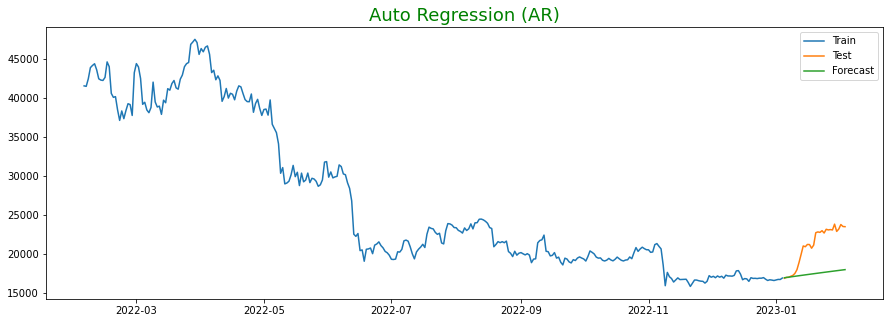

In [39]:
# plot the train, test & forecasted values
plt.figure(figsize=(15,5))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.title('Auto Regression (AR)', fontsize=18, color='green');

In [40]:
#evaluate the model
rmse=np.sqrt(mean_squared_error(test['Close'],forecast)).round(2)
mape=mean_absolute_percentage_error(test['Close'],forecast).round(4)*100

result=pd.DataFrame({'Method':["AR"], 'RMSE':[rmse],'MAPE':[mape]})
results=pd.concat([results,result])
results

Method     RMSE   MAPE
0                   Naive Method  4836.15  18.74
0          Simple Average Method  6218.02  29.07
0          Simple Moving Average  3083.26  12.30
0  Simple Explonential Smoothing  4840.60  18.76
0              Holt's With Trend  5239.54  20.35
0          Holt Winters Additive  4318.63  16.98
0    Holt Winters Multiplicative  6634.56  25.32
0                             AR  4200.70  16.20

### 9. Moving Average (MA)

In [41]:
model=sm.tsa.arima.ARIMA(train, order=(0,0,1))
model=model.fit()
forecast=model.forecast(test_len)
forecast

2023-01-05    21396.461529
2023-01-06    26786.273346
2023-01-07    26786.273346
2023-01-08    26786.273346
2023-01-09    26786.273346
2023-01-10    26786.273346
2023-01-11    26786.273346
2023-01-12    26786.273346
2023-01-13    26786.273346
2023-01-14    26786.273346
2023-01-15    26786.273346
2023-01-16    26786.273346
2023-01-17    26786.273346
2023-01-18    26786.273346
2023-01-19    26786.273346
2023-01-20    26786.273346
2023-01-21    26786.273346
2023-01-22    26786.273346
2023-01-23    26786.273346
2023-01-24    26786.273346
2023-01-25    26786.273346
2023-01-26    26786.273346
2023-01-27    26786.273346
2023-01-28    26786.273346
2023-01-29    26786.273346
2023-01-30    26786.273346
2023-01-31    26786.273346
2023-02-01    26786.273346
2023-02-02    26786.273346
2023-02-03    26786.273346
Freq: D, Name: predicted_mean, dtype: float64

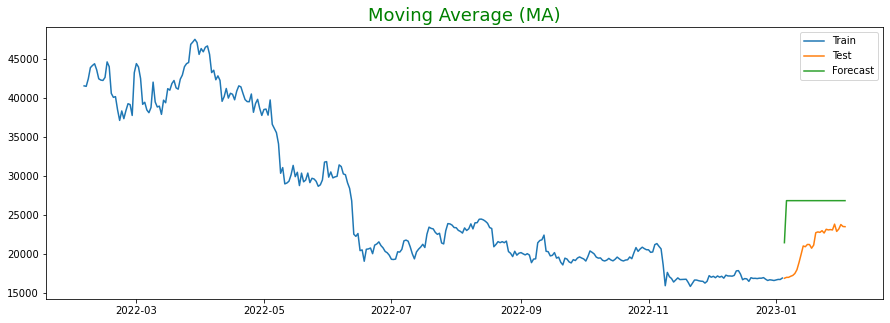

In [42]:
# plot the train, test & forecasted values
plt.figure(figsize=(15,5))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.title('Moving Average (MA)', fontsize=18, color='green');

In [43]:
#evaluate the model
rmse=np.sqrt(mean_squared_error(test['Close'],forecast)).round(2)
mape=mean_absolute_percentage_error(test['Close'],forecast).round(4)*100

result=pd.DataFrame({'Method':["MA"], 'RMSE':[rmse],'MAPE':[mape]})
results=pd.concat([results,result])
results

Method     RMSE   MAPE
0                   Naive Method  4836.15  18.74
0          Simple Average Method  6218.02  29.07
0          Simple Moving Average  3083.26  12.30
0  Simple Explonential Smoothing  4840.60  18.76
0              Holt's With Trend  5239.54  20.35
0          Holt Winters Additive  4318.63  16.98
0    Holt Winters Multiplicative  6634.56  25.32
0                             AR  4200.70  16.20
0                             MA  6009.78  28.03

### 10. Auto Regression Moving Average (ARMA)

In [44]:
model=sm.tsa.arima.ARIMA(train, order=(1,0,1))
model=model.fit()
forecast=model.forecast(test_len)
forecast

2023-01-05    16895.995322
2023-01-06    16931.863074
2023-01-07    16967.600679
2023-01-08    17003.208612
2023-01-09    17038.687342
2023-01-10    17074.037337
2023-01-11    17109.259066
2023-01-12    17144.352993
2023-01-13    17179.319583
2023-01-14    17214.159297
2023-01-15    17248.872595
2023-01-16    17283.459937
2023-01-17    17317.921779
2023-01-18    17352.258577
2023-01-19    17386.470785
2023-01-20    17420.558854
2023-01-21    17454.523235
2023-01-22    17488.364377
2023-01-23    17522.082727
2023-01-24    17555.678730
2023-01-25    17589.152831
2023-01-26    17622.505471
2023-01-27    17655.737092
2023-01-28    17688.848133
2023-01-29    17721.839031
2023-01-30    17754.710221
2023-01-31    17787.462140
2023-02-01    17820.095218
2023-02-02    17852.609888
2023-02-03    17885.006579
Freq: D, Name: predicted_mean, dtype: float64

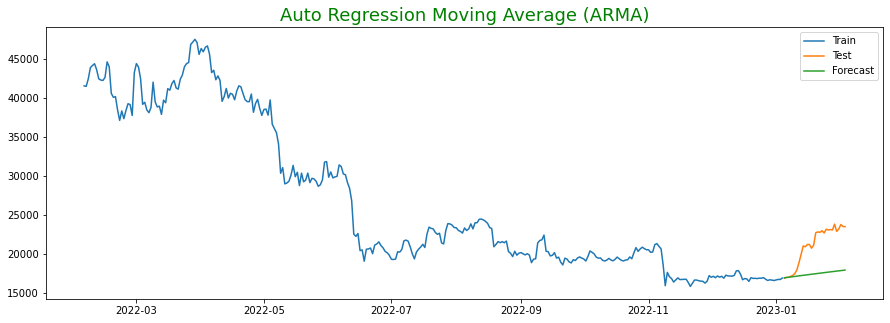

In [45]:
# plot the train, test & forecasted values
plt.figure(figsize=(15,5))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.title('Auto Regression Moving Average (ARMA)', fontsize=18, color='green');

In [46]:
#evaluate the model
rmse=np.sqrt(mean_squared_error(test['Close'],forecast)).round(2)
mape=mean_absolute_percentage_error(test['Close'],forecast).round(4)*100

result=pd.DataFrame({'Method':["ARMA"], 'RMSE':[rmse],'MAPE':[mape]})
results=pd.concat([results,result])
results

Method     RMSE   MAPE
0                   Naive Method  4836.15  18.74
0          Simple Average Method  6218.02  29.07
0          Simple Moving Average  3083.26  12.30
0  Simple Explonential Smoothing  4840.60  18.76
0              Holt's With Trend  5239.54  20.35
0          Holt Winters Additive  4318.63  16.98
0    Holt Winters Multiplicative  6634.56  25.32
0                             AR  4200.70  16.20
0                             MA  6009.78  28.03
0                           ARMA  4235.14  16.34

### 11.  Auto Regressive Integrated Moving Average (ARIMA)

In [47]:
model=sm.tsa.arima.ARIMA(train, order=(1,1,1))
model=model.fit()
forecast=model.forecast(test_len)
forecast

2023-01-05    16866.024331
2023-01-06    16867.945577
2023-01-07    16869.270459
2023-01-08    16870.184090
2023-01-09    16870.814125
2023-01-10    16871.248595
2023-01-11    16871.548202
2023-01-12    16871.754810
2023-01-13    16871.897286
2023-01-14    16871.995537
2023-01-15    16872.063290
2023-01-16    16872.110012
2023-01-17    16872.142231
2023-01-18    16872.164450
2023-01-19    16872.179771
2023-01-20    16872.190337
2023-01-21    16872.197623
2023-01-22    16872.202647
2023-01-23    16872.206112
2023-01-24    16872.208502
2023-01-25    16872.210149
2023-01-26    16872.211285
2023-01-27    16872.212069
2023-01-28    16872.212609
2023-01-29    16872.212982
2023-01-30    16872.213239
2023-01-31    16872.213416
2023-02-01    16872.213538
2023-02-02    16872.213622
2023-02-03    16872.213681
Freq: D, Name: predicted_mean, dtype: float64

In [48]:
rmse=np.sqrt(mean_squared_error(test,forecast)).round(2)
rmse

4828.43

**Lets chhose correct order, ie value of p,q,d which leads to minimum RMSE.**

In [49]:
warnings.filterwarnings('ignore')
import itertools
p=range(0,10)
q=range(0,10)
d=range(0,4)
pdq=list(itertools.product(p,d,q))
len(pdq)

400

In [50]:
#rmse=[]
#order1=[]
#for pdq in pdq:
#    try:
#        model=sm.tsa.arima.ARIMA(train, order=pdq).fit()
#        pred=model.forecast(test_len)
#        error=np.sqrt(mean_squared_error(pred,test))
#        order1.append(pdq)
#        rmse.append(error)
#    except:
#        continue

In [51]:
#order=pd.DataFrame(data=rmse, index=order1, columns=['RMSE'])
#pd.pivot_table(order, values='RMSE', index=order.index, aggfunc=min).sort_values(by='RMSE', ascending=True)[:5].round()

In [52]:
model=sm.tsa.arima.ARIMA(train, order=(0,3,6))
model=model.fit()
forecast=model.forecast(test_len)
forecast

2023-01-05    17001.808940
2023-01-06    17155.847199
2023-01-07    17322.056850
2023-01-08    17489.393769
2023-01-09    17657.858027
2023-01-10    17833.176242
2023-01-11    18015.348416
2023-01-12    18204.374548
2023-01-13    18400.254637
2023-01-14    18602.988684
2023-01-15    18812.576690
2023-01-16    19029.018653
2023-01-17    19252.314574
2023-01-18    19482.464453
2023-01-19    19719.468290
2023-01-20    19963.326085
2023-01-21    20214.037838
2023-01-22    20471.603549
2023-01-23    20736.023217
2023-01-24    21007.296844
2023-01-25    21285.424429
2023-01-26    21570.405971
2023-01-27    21862.241471
2023-01-28    22160.930930
2023-01-29    22466.474346
2023-01-30    22778.871720
2023-01-31    23098.123052
2023-02-01    23424.228342
2023-02-02    23757.187590
2023-02-03    24097.000796
Freq: D, Name: predicted_mean, dtype: float64

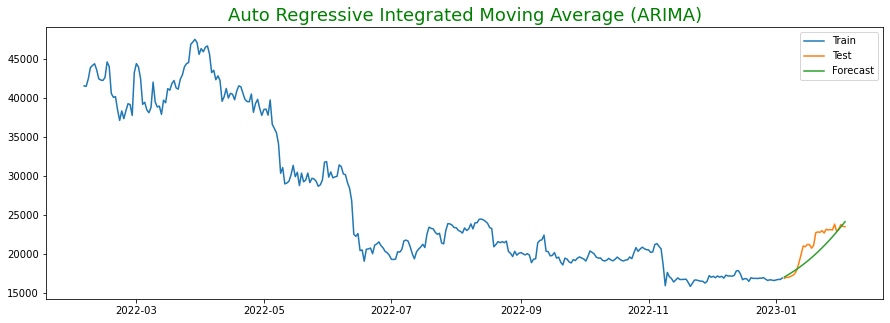

In [53]:
# plot the train, test & forecasted values
plt.figure(figsize=(15,5))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.title('Auto Regressive Integrated Moving Average (ARIMA)', fontsize=18, color='green');

In [54]:
#evaluate the model
rmse=np.sqrt(mean_squared_error(test['Close'],forecast)).round(2)
mape=mean_absolute_percentage_error(test['Close'],forecast).round(4)*100

result=pd.DataFrame({'Method':["ARIMA"], 'RMSE':[rmse],'MAPE':[mape]})
results=pd.concat([results,result])
results

Method     RMSE   MAPE
0                   Naive Method  4836.15  18.74
0          Simple Average Method  6218.02  29.07
0          Simple Moving Average  3083.26  12.30
0  Simple Explonential Smoothing  4840.60  18.76
0              Holt's With Trend  5239.54  20.35
0          Holt Winters Additive  4318.63  16.98
0    Holt Winters Multiplicative  6634.56  25.32
0                             AR  4200.70  16.20
0                             MA  6009.78  28.03
0                           ARMA  4235.14  16.34
0                          ARIMA  1430.99   5.34

### 12 Seasonal Auto Regressive Integrated Moving Average (SARIMA)

In [55]:
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1, 1, 1, 12)) 
model= model.fit()
forecast=model.forecast(test_len)
forecast

2023-01-05    17009.049543
2023-01-06    17168.685393
2023-01-07    17174.677649
2023-01-08    16843.296761
2023-01-09    16606.121818
2023-01-10    16686.266910
2023-01-11    16662.747086
2023-01-12    16491.084903
2023-01-13    16728.088712
2023-01-14    16720.979524
2023-01-15    16713.166817
2023-01-16    16797.765574
2023-01-17    16929.268624
2023-01-18    17064.221050
2023-01-19    17080.885157
2023-01-20    16768.864571
2023-01-21    16542.473373
2023-01-22    16624.142154
2023-01-23    16598.108693
2023-01-24    16443.983445
2023-01-25    16657.034790
2023-01-26    16660.564118
2023-01-27    16652.548926
2023-01-28    16752.020887
2023-01-29    16885.583687
2023-01-30    17024.314557
2023-01-31    17039.298168
2023-02-01    16724.461379
2023-02-02    16496.372934
2023-02-03    16577.896173
Freq: D, Name: predicted_mean, dtype: float64

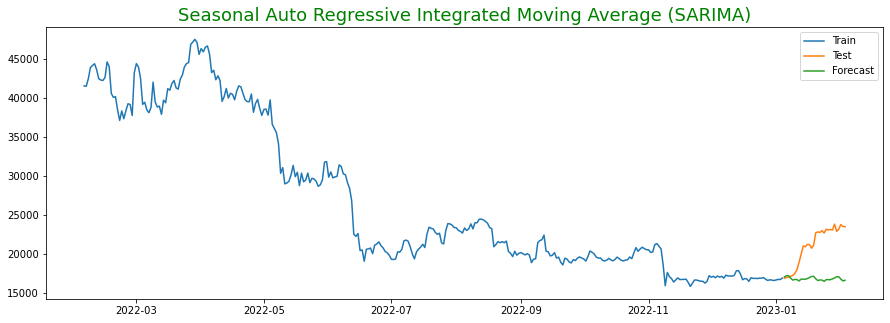

In [56]:
# plot the train, test & forecasted values
plt.figure(figsize=(15,5))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.title('Seasonal Auto Regressive Integrated Moving Average (SARIMA)', fontsize=18, color='green');

In [57]:
#evaluate the model
rmse=np.sqrt(mean_squared_error(test['Close'],forecast)).round(2)
mape=mean_absolute_percentage_error(test['Close'],forecast).round(4)*100

result=pd.DataFrame({'Method':["SARIMA"], 'RMSE':[rmse],'MAPE':[mape]})
results=pd.concat([results,result])
results

Method     RMSE   MAPE
0                   Naive Method  4836.15  18.74
0          Simple Average Method  6218.02  29.07
0          Simple Moving Average  3083.26  12.30
0  Simple Explonential Smoothing  4840.60  18.76
0              Holt's With Trend  5239.54  20.35
0          Holt Winters Additive  4318.63  16.98
0    Holt Winters Multiplicative  6634.56  25.32
0                             AR  4200.70  16.20
0                             MA  6009.78  28.03
0                           ARMA  4235.14  16.34
0                          ARIMA  1430.99   5.34
0                         SARIMA  4953.32  19.37

### Forecast Bitcoin price for next 30 days

In [58]:
model=sm.tsa.arima.ARIMA(train, order=(0,3,6))
model=model.fit()
forecast=model.forecast(test_len+30)
forecast

2023-01-05    17001.808940
2023-01-06    17155.847199
2023-01-07    17322.056850
2023-01-08    17489.393769
2023-01-09    17657.858027
2023-01-10    17833.176242
2023-01-11    18015.348416
2023-01-12    18204.374548
2023-01-13    18400.254637
2023-01-14    18602.988684
2023-01-15    18812.576690
2023-01-16    19029.018653
2023-01-17    19252.314574
2023-01-18    19482.464453
2023-01-19    19719.468290
2023-01-20    19963.326085
2023-01-21    20214.037838
2023-01-22    20471.603549
2023-01-23    20736.023217
2023-01-24    21007.296844
2023-01-25    21285.424429
2023-01-26    21570.405971
2023-01-27    21862.241471
2023-01-28    22160.930930
2023-01-29    22466.474346
2023-01-30    22778.871720
2023-01-31    23098.123052
2023-02-01    23424.228342
2023-02-02    23757.187590
2023-02-03    24097.000796
2023-02-04    24443.667960
2023-02-05    24797.189081
2023-02-06    25157.564161
2023-02-07    25524.793198
2023-02-08    25898.876194
2023-02-09    26279.813147
2023-02-10    26667.604059
2

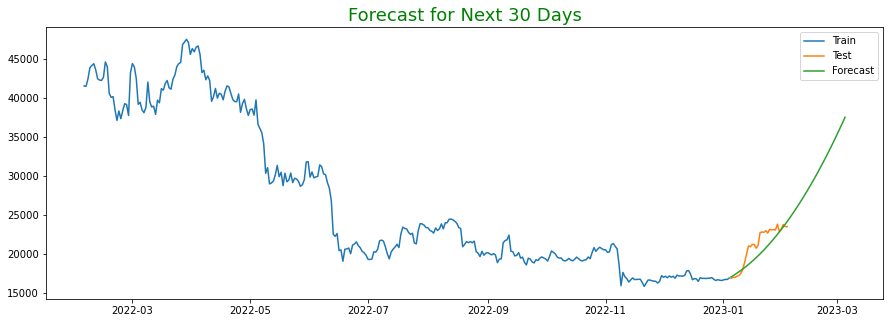

In [59]:
# plot the train, test & forecasted values
plt.figure(figsize=(15,5))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.title('Forecast for Next 30 Days', fontsize=18, color='green');

### Conclusion:
1. **Actual model used for Forecasting is ARIMA with order (0,3,6)**
2. **Forecasted next 30 days BitCoin Price.**